# Data Import

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/ColabData/PlantVillage_Tomato

Mounted at /content/drive
/content/drive/MyDrive/ColabData/PlantVillage_Tomato


In [ ]:
# The following few code blocks are to print sample images from each class

class_folders = [folder for folder in os.listdir('.') if os.path.isdir(folder)]
class_folders.remove("Healthy")
print(class_folders)

['Septoria_Leaf_Spot', 'Bacterial_Spot', 'Early_Blight', 'Mosaic_Virus', 'Two_Spotted_Spider_Mite', 'Target_Spot', 'Leaf_Mold', 'Late_Blight', 'Yellowleaf__Curl_Virus']


In [ ]:
image_paths = []
labels = []

for folder in class_folders:
  folder_path = os.path.join('.', folder)
  image_files = [f for f in os.listdir(folder_path)]
  chosen_image = image_files[0]
  image_paths.append(os.path.join(folder_path, chosen_image))
  labels.append(folder)
print(image_paths)

['./Septoria_Leaf_Spot/0ab271a7-765e-4675-8bfc-e249c0c86fdd___Keller.St_CG 1778.JPG', './Bacterial_Spot/990802e1-42e5-4646-8051-f07027f6ca2c___GCREC_Bact.Sp 3213.JPG', './Early_Blight/13c87a78-0a62-4aff-b6f3-fcbf1a8323e6___RS_Erly.B 9612.JPG', './Mosaic_Virus/146eaf68-7f61-4717-ac81-2f8bb4533fec___PSU_CG 2406.JPG', './Two_Spotted_Spider_Mite/4ab2b9cc-67cd-417c-934c-5e76a4f9fa49___Com.G_SpM_FL 8845.JPG', './Target_Spot/1c449341-6c92-4eeb-b83a-536d23ebbe96___Com.G_TgS_FL 8011.JPG', './Leaf_Mold/7c8dcf96-0825-49a2-8309-bb02524c64da___Crnl_L.Mold 8775.JPG', './Late_Blight/06471eca-3cac-4cc9-afc3-1841af0ba672___GHLB2 Leaf 8893.JPG', './Yellowleaf__Curl_Virus/781bb07e-cb0f-4a17-b44e-1f372906bf32___UF.GRC_YLCV_Lab 03367.JPG']


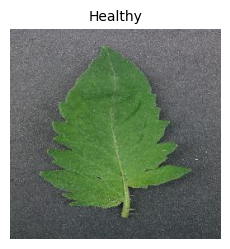

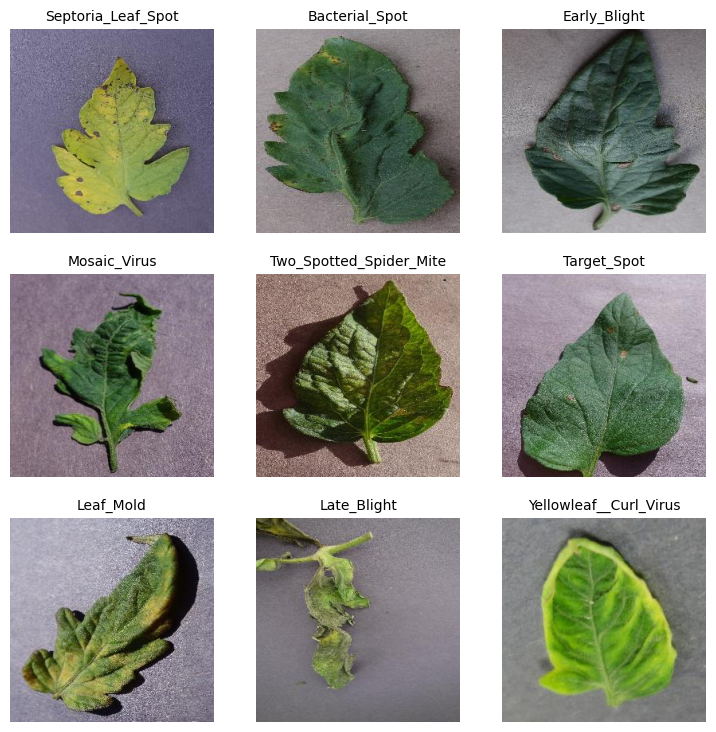

In [ ]:
healthy_folder = os.path.join('.', 'Healthy')
healthy_images = [f for f in os.listdir(healthy_folder)]
img_path = os.path.join(healthy_folder, healthy_images[0])
img = Image.open(img_path)

plt.figure(figsize=(2.73, 2.73))
plt.imshow(img)
plt.title("Healthy", fontsize=10)
plt.axis('off')
plt.show()

plt.figure(figsize=(9, 9))
for i, img_path in enumerate(image_paths):
    plt.subplot(3, 3, i + 1)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(labels[i], fontsize=10)
    plt.axis('off')

# Data Cleaning and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
'''
# Calculating mean and std dev for dataset

# temporary transforms and dataloader
stats_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Use the same root as your dataset ('.')
stats_dataset = datasets.ImageFolder(root='.', transform=stats_transform)
stats_loader = DataLoader(stats_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

mean = 0.0
std = 0.0
total_images = 0

# calculations for mean and std dev
for images, _ in stats_loader:
    batch_samples = images.size(0)  # number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Calculated mean:", mean)
print("Calculated std:", std)
'''

'\n# Calculating mean and std dev for dataset\n\n# temporary transforms and dataloader\nstats_transform = transforms.Compose([\n    transforms.Resize((128, 128)),\n    transforms.ToTensor()\n])\n\n# Use the same root as your dataset (\'.\')\nstats_dataset = datasets.ImageFolder(root=\'.\', transform=stats_transform)\nstats_loader = DataLoader(stats_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)\n\nmean = 0.0\nstd = 0.0\ntotal_images = 0\n\n# calculations for mean and std dev\nfor images, _ in stats_loader:\n    batch_samples = images.size(0)  # number of images in the batch\n    images = images.view(batch_samples, images.size(1), -1)\n    mean += images.mean(2).sum(0)\n    std += images.std(2).sum(0)\n    total_images += batch_samples\n\nmean /= total_images\nstd /= total_images\n\nprint("Calculated mean:", mean)\nprint("Calculated std:", std)\n'

In [ ]:
MEAN = [0.4516, 0.4654, 0.4073]
STD = [0.1550, 0.1325, 0.1726]

In [ ]:
# Train transforms - horizontal flip, rotations, normalization
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [ ]:
# Test transforms - normalization
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [ ]:
# Creating 'ImageFolder' type, which automatically labels every image
full_dataset = datasets.ImageFolder(root='.', transform=train_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 16011
    Root location: .
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.4516, 0.4654, 0.4073], std=[0.155, 0.1325, 0.1726])
           )

In [ ]:
# 70-15-15 split
# final_test: test set that will be used
# train_val: the training and validation set combined, will be split after
total_size = len(full_dataset)
final_test_size = int(total_size * 0.15)
train_val_size = total_size - final_test_size
val_size = int(train_val_size * 0.15)
train_size = train_val_size - val_size

train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, final_test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

In [ ]:
# Shuffle train but not test to train model better
# Batch size 32 chosen to keep CPU load low (ran out of colab GPU credits)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# CNN Setup

In [ ]:
# Model pipeline - 3 layers
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        # Define program flow
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [ ]:
model=Network()
model.to(device)

Network(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# Training
### DO NOT RUN (30 min runtime)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ColabData/model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
import time
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

EPOCHS = 20
t0 = time.time()

for epoch in range(EPOCHS):
    t1 = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

    checkpoint = {
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

    print(f"Epoch Time: {round((time.time() - t1)/60, 2)}\n")

print(f"Total time: {round((time.time() - t0)/60, 2)}")

Epoch [1/20], Train Loss: 0.9518, Train Acc: 67.08%, Validation Loss: 0.4331, Validation Acc: 85.74%
Checkpoint saved to /content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_1.pth
Epoch Time: 0.94

Epoch [2/20], Train Loss: 0.4456, Train Acc: 85.05%, Validation Loss: 0.3833, Validation Acc: 88.58%
Checkpoint saved to /content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_2.pth
Epoch Time: 1.01

Epoch [3/20], Train Loss: 0.3036, Train Acc: 89.76%, Validation Loss: 0.2921, Validation Acc: 91.62%
Checkpoint saved to /content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_3.pth
Epoch Time: 0.97

Epoch [4/20], Train Loss: 0.2243, Train Acc: 92.56%, Validation Loss: 0.3142, Validation Acc: 91.33%
Checkpoint saved to /content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_4.pth
Epoch Time: 0.99

Epoch [5/20], Train Loss: 0.1717, Train Acc: 94.50%, Validation Loss: 0.2700, Validation Acc: 94.56%
Checkpoint saved to /content/drive/MyDrive/Cola

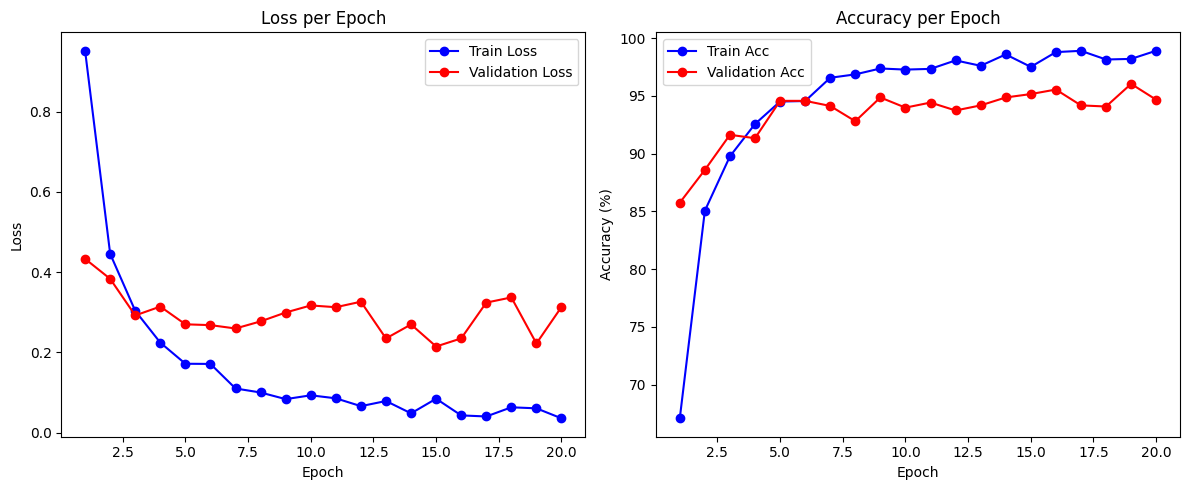

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Acc')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Testing
### 1.5 min runtime

In [ ]:
# Based on the graphs above, epoch 19 seems to have the best results
best_ckpt = '/content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_19.pth'

checkpoint = torch.load(best_ckpt, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()

print("Loaded checkpoint from epoch", checkpoint['epoch'])

Loaded checkpoint from epoch 19


In [ ]:
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc  = 100 * correct / total

print(f"Final Test   Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

KeyboardInterrupt: 

# Results

In [ ]:
# Based on the graphs above, epoch 19 seems to have the best results
best_ckpt = '/content/drive/MyDrive/ColabData/model_checkpoints/checkpoint_epoch_19.pth'

checkpoint = torch.load(best_ckpt, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()

print("Loaded checkpoint from epoch", checkpoint['epoch'])

Loaded checkpoint from epoch 19


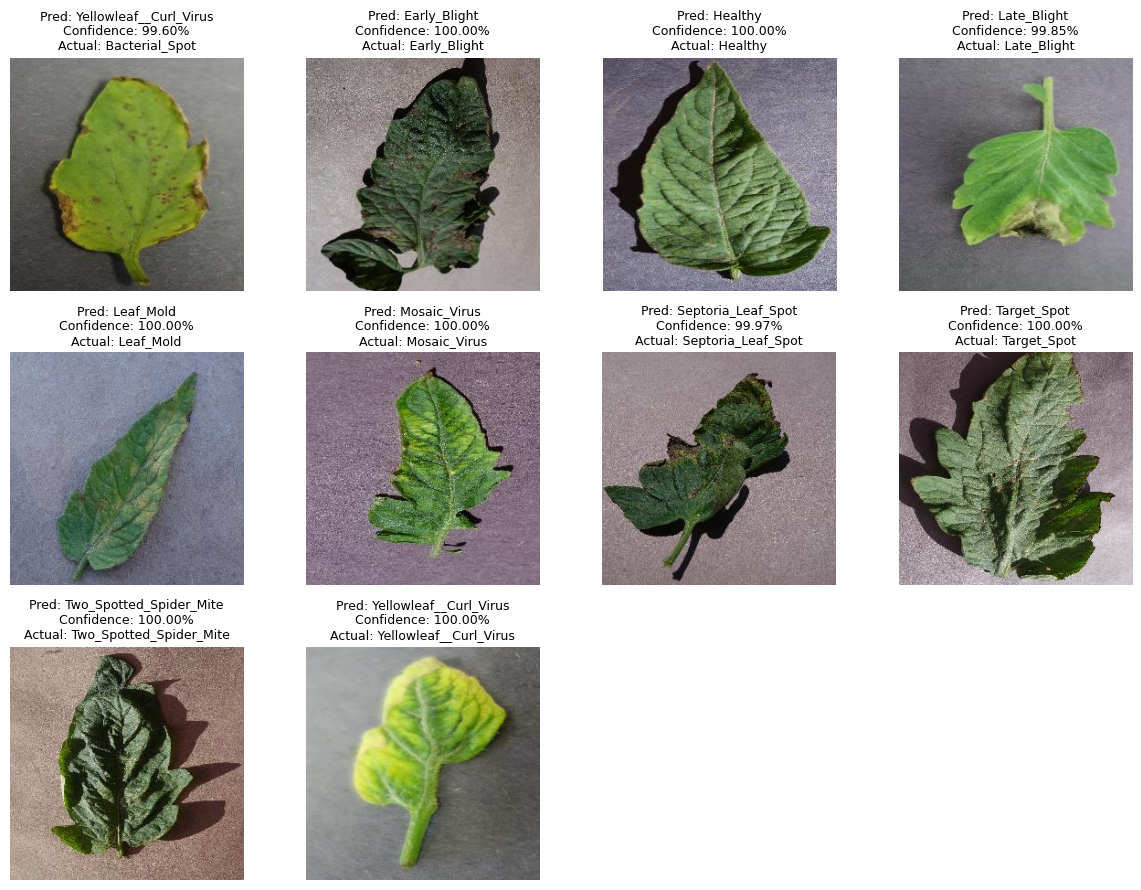

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import math

root_dir = '/content/drive/MyDrive/ColabData/PlantVillage_Tomato'

class_names = full_dataset.classes

# randomly pick an image from each class
random.seed(73)
samples = []
for cls in class_names:
    cls_dir = os.path.join(root_dir, cls)

    imgs = [f for f in os.listdir(cls_dir)]
    chosen = random.choice(imgs)
    samples.append((os.path.join(cls_dir, chosen), cls))

# subplot settings
n = len(samples)
cols = 4
rows = math.ceil(n/cols)
plt.figure(figsize=(cols*3, rows*3))

# run model on each image
model.eval()
for i, (path, true_label) in enumerate(samples):
    img = Image.open(path).convert('RGB')
    inp = test_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out   = model(inp)
        probs = F.softmax(out, dim=1)
        conf, pred_idx = probs.max(1)
    pred_label = class_names[pred_idx.item()]
    conf_pct   = conf.item() * 100

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.set_title(f"Pred: {pred_label}\nConfidence: {conf_pct:.2f}%\nActual: {true_label}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(class_names)

['Bacterial_Spot', 'Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Mosaic_Virus', 'Septoria_Leaf_Spot', 'Target_Spot', 'Two_Spotted_Spider_Mite', 'Yellowleaf__Curl_Virus']
